# Exploratory Data Analysis: MIS and MVC Tasks

This notebook performs exploratory data analysis on the Maximum Independent Set (MIS) and Minimum Vertex Cover (MVC) graph problems from the dataset folder.

## 1. Import Libraries and Load Data

In [2]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load all dataset files
dataset_files = ['0shot.json', '1shot.json', '2shot.json', '3shot.json', '4shot.json']
all_data = {}

for file in dataset_files:
    filepath = f'dataset/{file}'
    with open(filepath, 'r') as f:
        all_data[file] = json.load(f)
    print(f"Loaded {file}: {len(all_data[file])} task types")

print(f"\nDataset files loaded: {list(all_data.keys())}")
print(f"Task types available: {list(all_data['0shot.json'].keys())}")

Loaded 0shot.json: 10 task types
Loaded 1shot.json: 10 task types
Loaded 2shot.json: 10 task types
Loaded 3shot.json: 10 task types
Loaded 4shot.json: 10 task types

Dataset files loaded: ['0shot.json', '1shot.json', '2shot.json', '3shot.json', '4shot.json']
Task types available: ['Connected', 'Diameter', 'Distance', 'Neighbor', 'MCP', 'MIS', 'MVC', 'TSP', 'MCS', 'GED']


## 2. Parse Graph Data from MIS and MVC Problems

In [4]:
def parse_graph_from_text(problem_text):
    """
    Parse graph information from MIS/MVC problem text.
    Returns: nodes (list), edges (list of tuples), difficulty ('easy' or 'hard')
    """
    # Extract nodes (users in the network)
    users_pattern = r"Users in the network:\s*([^.]+)\."
    users_match = re.search(users_pattern, problem_text)
    
    if users_match:
        users_text = users_match.group(1)
        # Split by commas and clean up
        nodes = [name.strip() for name in users_text.split(',')]
    else:
        nodes = []
    
    # Extract edges (friendship connections)
    edges = []
    # Pattern to find friendship connections
    connections_pattern = r"(\w+\s+\w+)\s+and\s+(\w+\s+\w+)"
    connections_matches = re.findall(connections_pattern, problem_text)
    
    for match in connections_matches:
        edges.append((match[0].strip(), match[1].strip()))
    
    return nodes, edges

# Test the parser
sample_mis = all_data['0shot.json']['MIS']['easy'][0]
nodes, edges = parse_graph_from_text(sample_mis)
print(f"Sample MIS Easy Problem:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"Nodes: {nodes[:5]}...")
print(f"Edges: {edges[:5]}...")

Sample MIS Easy Problem:
Number of nodes: 4
Number of edges: 4
Nodes: ['William Lawson', 'Daniel Shelton', 'Michelle Lewis', 'Julie Hayes']...
Edges: [('William Lawson', 'Daniel Shelton'), ('William Lawson', 'Julie Hayes'), ('Michelle Lewis', 'Julie Hayes'), ('this network', 'present your')]...


In [5]:
def extract_all_graph_stats(data_dict, task_name, difficulty):
    """
    Extract graph statistics from all problems in a task/difficulty combination
    """
    stats = []
    problems = data_dict[task_name][difficulty]
    
    for idx, problem_text in enumerate(problems):
        nodes, edges = parse_graph_from_text(problem_text)
        
        # Create NetworkX graph
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        
        # Calculate statistics
        stat_dict = {
            'task': task_name,
            'difficulty': difficulty,
            'problem_id': idx,
            'num_nodes': len(nodes),
            'num_edges': len(edges),
            'density': nx.density(G) if len(nodes) > 0 else 0,
            'avg_degree': sum(dict(G.degree()).values()) / len(nodes) if len(nodes) > 0 else 0,
            'max_degree': max(dict(G.degree()).values()) if len(nodes) > 0 else 0,
            'min_degree': min(dict(G.degree()).values()) if len(nodes) > 0 else 0,
            'is_connected': nx.is_connected(G) if len(nodes) > 0 else False,
            'num_components': nx.number_connected_components(G) if len(nodes) > 0 else 0,
        }
        
        # Add clustering coefficient if graph has edges
        if len(edges) > 0:
            stat_dict['avg_clustering'] = nx.average_clustering(G)
        else:
            stat_dict['avg_clustering'] = 0
            
        # Add diameter for connected graphs
        if stat_dict['is_connected'] and len(nodes) > 1:
            stat_dict['diameter'] = nx.diameter(G)
        else:
            stat_dict['diameter'] = None
            
        stats.append(stat_dict)
    
    return stats

# Extract stats for MIS and MVC from 0shot dataset
print("Extracting graph statistics for MIS and MVC...")
all_stats = []

for task in ['MIS', 'MVC']:
    for difficulty in ['easy', 'hard']:
        stats = extract_all_graph_stats(all_data['0shot.json'], task, difficulty)
        all_stats.extend(stats)
        print(f"Processed {task} - {difficulty}: {len(stats)} problems")

# Create DataFrame
df_stats = pd.DataFrame(all_stats)
print(f"\nTotal problems analyzed: {len(df_stats)}")
print(f"\nDataFrame shape: {df_stats.shape}")
df_stats.head()

Extracting graph statistics for MIS and MVC...
Processed MIS - easy: 500 problems
Processed MIS - hard: 500 problems
Processed MVC - easy: 500 problems
Processed MVC - hard: 500 problems

Total problems analyzed: 2000

DataFrame shape: (2000, 13)


,task,difficulty,problem_id,num_nodes,num_edges,density,avg_degree,max_degree,min_degree,is_connected,num_components,avg_clustering,diameter
0,MIS,easy,0,4,4,0.266667,2.000000,2,1,False,2,0.000000,None
1,MIS,easy,1,3,11,0.120879,7.333333,6,0,False,3,0.000000,None
2,MIS,easy,2,5,5,0.238095,2.000000,4,1,False,2,0.000000,None
3,MIS,easy,3,4,5,0.178571,2.500000,3,0,False,3,0.000000,None
4,MIS,easy,4,9,14,0.254545,3.111111,8,1,False,2,0.349567,None


## 3. Basic Statistics Overview

In [6]:
# Summary statistics by task and difficulty
print("="*80)
print("SUMMARY STATISTICS BY TASK AND DIFFICULTY")
print("="*80)

summary = df_stats.groupby(['task', 'difficulty']).agg({
    'num_nodes': ['mean', 'std', 'min', 'max'],
    'num_edges': ['mean', 'std', 'min', 'max'],
    'density': ['mean', 'std'],
    'avg_degree': ['mean', 'std'],
    'max_degree': ['mean', 'max'],
    'is_connected': 'sum',
    'avg_clustering': 'mean'
}).round(2)

print(summary)
print("\n")

SUMMARY STATISTICS BY TASK AND DIFFICULTY
                num_nodes               num_edges                 density  \
                     mean   std min max      mean    std min  max    mean   
task difficulty                                                             
MIS  easy            6.36  2.64   1  14      8.74   6.57   1   78    0.24   
     hard           15.77  6.02   1  29     31.40  17.84   6  142    0.14   
MVC  easy            8.13  3.26   1  14     14.36   7.10   5   65    0.27   
     hard           15.75  6.34   1  30     33.53  18.53   9  149    0.15   

                      avg_degree       max_degree     is_connected  \
                  std       mean   std       mean max          sum   
task difficulty                                                      
MIS  easy        0.08       2.93  2.33       5.03  13            0   
     hard        0.07       6.07  9.48      13.23  28            0   
MVC  easy        0.11       4.41  4.78       6.85  13            0  

In [7]:
# Detailed statistics table
print("Detailed Statistics for MIS:")
print(df_stats[df_stats['task'] == 'MIS'][['difficulty', 'num_nodes', 'num_edges', 'density', 'avg_degree', 'is_connected']].describe())

print("\n" + "="*80 + "\n")

print("Detailed Statistics for MVC:")
print(df_stats[df_stats['task'] == 'MVC'][['difficulty', 'num_nodes', 'num_edges', 'density', 'avg_degree', 'is_connected']].describe())

Detailed Statistics for MIS:
         num_nodes    num_edges      density   avg_degree
count  1000.000000  1000.000000  1000.000000  1000.000000
mean     11.069000    20.070000     0.190553     4.501886
std       6.612561    17.583181     0.086401     7.076502
min       1.000000     1.000000     0.023715     0.500000
25%       5.000000     7.000000     0.117647     2.000000
50%       9.000000    16.000000     0.178571     2.533333
75%      16.000000    27.000000     0.238095     4.000000
max      29.000000   142.000000     0.681319   102.000000


Detailed Statistics for MVC:
         num_nodes    num_edges      density   avg_degree
count  1000.000000  1000.000000  1000.000000  1000.000000
mean     11.938000    23.945000     0.208074     5.312902
std       6.320451    16.990369     0.108836     6.489805
min       1.000000     5.000000     0.056452     1.500000
25%       7.000000    13.000000     0.126316     2.622596
50%      11.000000    20.000000     0.176147     3.387960
75%      16.

## 4. Visualization: Graph Size Distribution

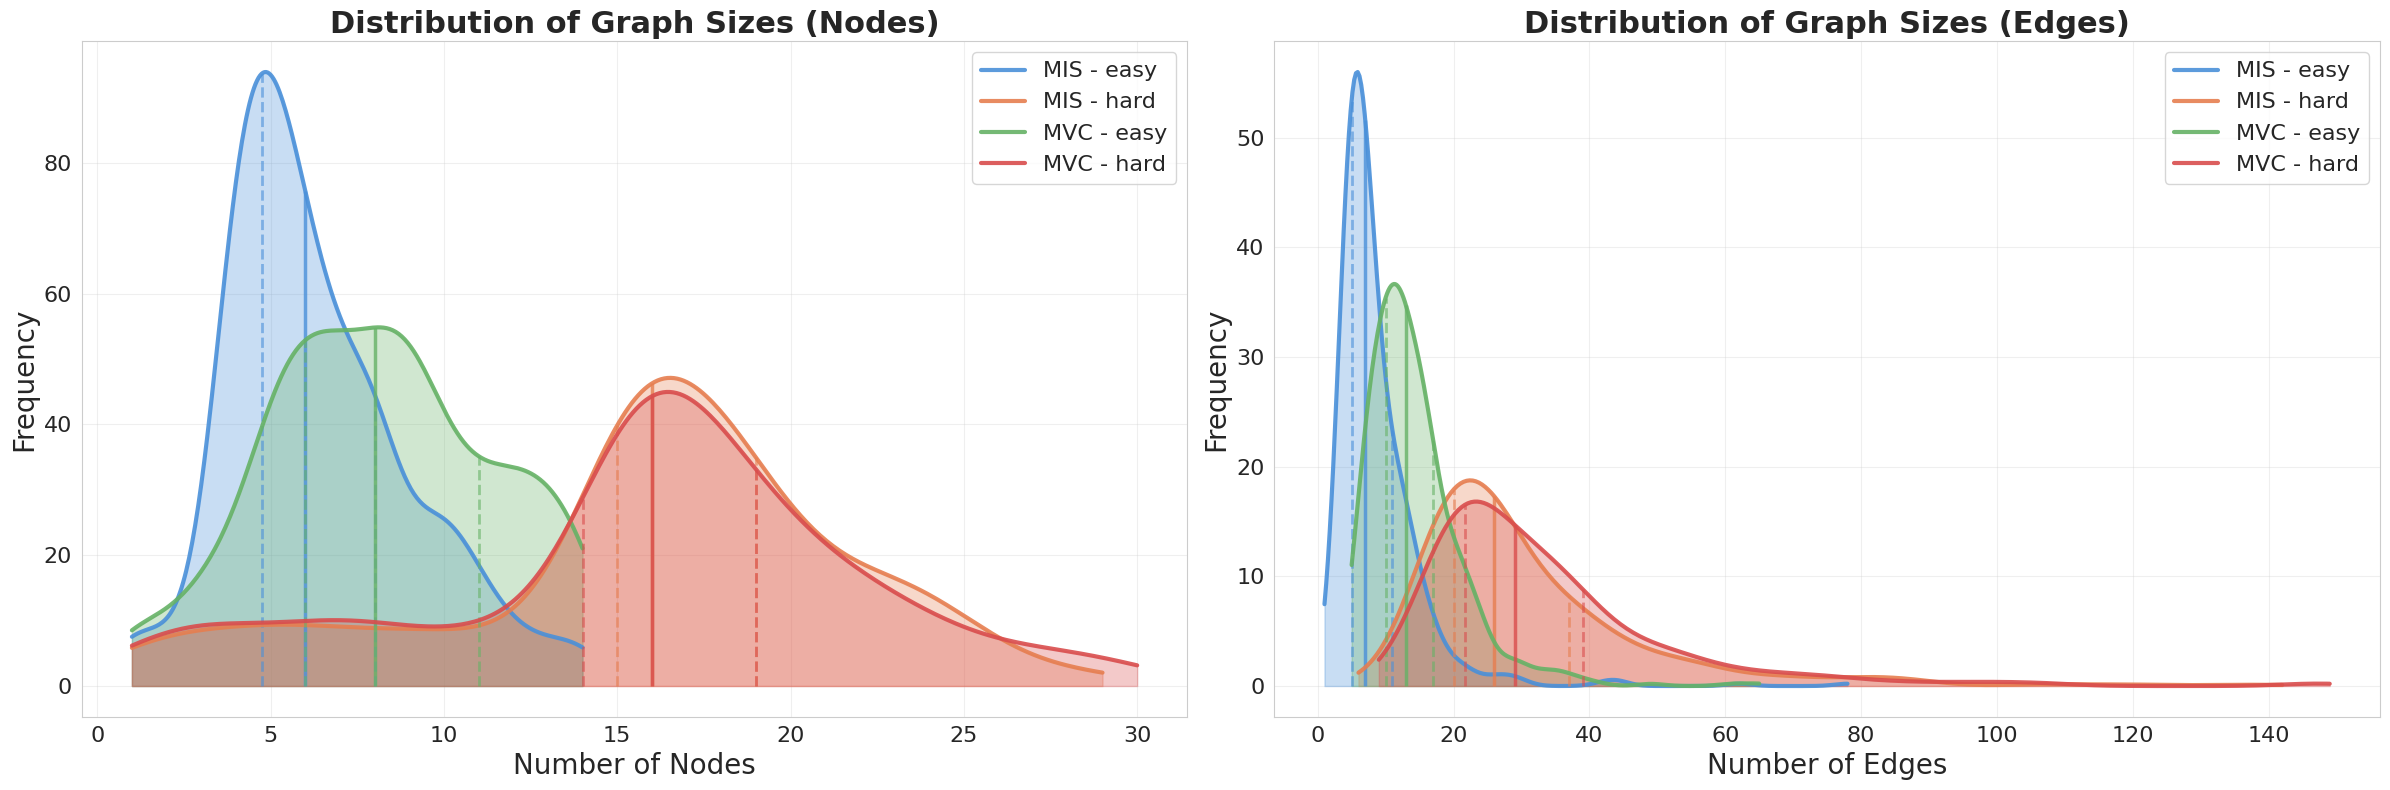

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Import scipy.stats for KDE
from scipy import stats

# Define distinct but darker colors for each task-difficulty combination
color_map = {
    ('MIS', 'easy'): '#4A90D9',    # Darker blue
    ('MIS', 'hard'): '#E67E50',    # Darker orange
    ('MVC', 'easy'): '#66B266',    # Darker green
    ('MVC', 'hard'): '#D94D4D'     # Darker red
}

# 1. Number of Nodes Distribution - KDE scaled to raw counts
for task in ['MIS', 'MVC']:
    for diff in ['easy', 'hard']:
        data = df_stats[(df_stats['task'] == task) & (df_stats['difficulty'] == diff)]['num_nodes']
        
        # Create KDE
        kde = stats.gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 300)
        
        # Calculate density and scale to raw counts
        density = kde(x_range)
        scaled_density = density * len(data)  # Scale to raw frequency
        
        color = color_map[(task, diff)]
        axes[0].plot(x_range, scaled_density, label=f'{task} - {diff}', 
                       color=color, linewidth=3, alpha=0.9)
        axes[0].fill_between(x_range, scaled_density, alpha=0.3, color=color)
        
        # Add quartile lines - with heights at the density curve at those points
        q1, q2, q3 = data.quantile([0.25, 0.5, 0.75])
        
        # Get the height of the curve at each quartile position
        q1_height = kde(q1)[0] * len(data)
        q2_height = kde(q2)[0] * len(data)
        q3_height = kde(q3)[0] * len(data)
        
        # Q1 - dashed line (from 0 to density at Q1)
        axes[0].vlines(q1, 0, q1_height, colors=color, linestyles='--', linewidth=2, alpha=0.6)
        # Q2 (median) - solid line (from 0 to density at Q2)
        axes[0].vlines(q2, 0, q2_height, colors=color, linestyles='-', linewidth=2.5, alpha=0.8)
        # Q3 - dashed line (from 0 to density at Q3)
        axes[0].vlines(q3, 0, q3_height, colors=color, linestyles='--', linewidth=2, alpha=0.6)

axes[0].set_xlabel('Number of Nodes', fontsize=20)
axes[0].set_ylabel('Frequency', fontsize=20)
axes[0].set_title('Distribution of Graph Sizes (Nodes)', fontsize=22, fontweight='bold')
axes[0].legend(fontsize=16, loc='best')
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].grid(True, alpha=0.3)

# 2. Number of Edges Distribution - KDE scaled to raw counts
for task in ['MIS', 'MVC']:
    for diff in ['easy', 'hard']:
        data = df_stats[(df_stats['task'] == task) & (df_stats['difficulty'] == diff)]['num_edges']
        
        # Create KDE
        kde = stats.gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 300)
        
        # Calculate density and scale to raw counts
        density = kde(x_range)
        scaled_density = density * len(data)  # Scale to raw frequency
        
        color = color_map[(task, diff)]
        axes[1].plot(x_range, scaled_density, label=f'{task} - {diff}', 
                       color=color, linewidth=3, alpha=0.9)
        axes[1].fill_between(x_range, scaled_density, alpha=0.3, color=color)
        
        # Add quartile lines - with heights at the density curve at those points
        q1, q2, q3 = data.quantile([0.25, 0.5, 0.75])
        
        # Get the height of the curve at each quartile position
        q1_height = kde(q1)[0] * len(data)
        q2_height = kde(q2)[0] * len(data)
        q3_height = kde(q3)[0] * len(data)
        
        # Q1 - dashed line (from 0 to density at Q1)
        axes[1].vlines(q1, 0, q1_height, colors=color, linestyles='--', linewidth=2, alpha=0.6)
        # Q2 (median) - solid line (from 0 to density at Q2)
        axes[1].vlines(q2, 0, q2_height, colors=color, linestyles='-', linewidth=2.5, alpha=0.8)
        # Q3 - dashed line (from 0 to density at Q3)
        axes[1].vlines(q3, 0, q3_height, colors=color, linestyles='--', linewidth=2, alpha=0.6)

axes[1].set_xlabel('Number of Edges', fontsize=20)
axes[1].set_ylabel('Frequency', fontsize=20)
axes[1].set_title('Distribution of Graph Sizes (Edges)', fontsize=22, fontweight='bold')
axes[1].legend(fontsize=16, loc='best')
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Visualization: Graph Properties

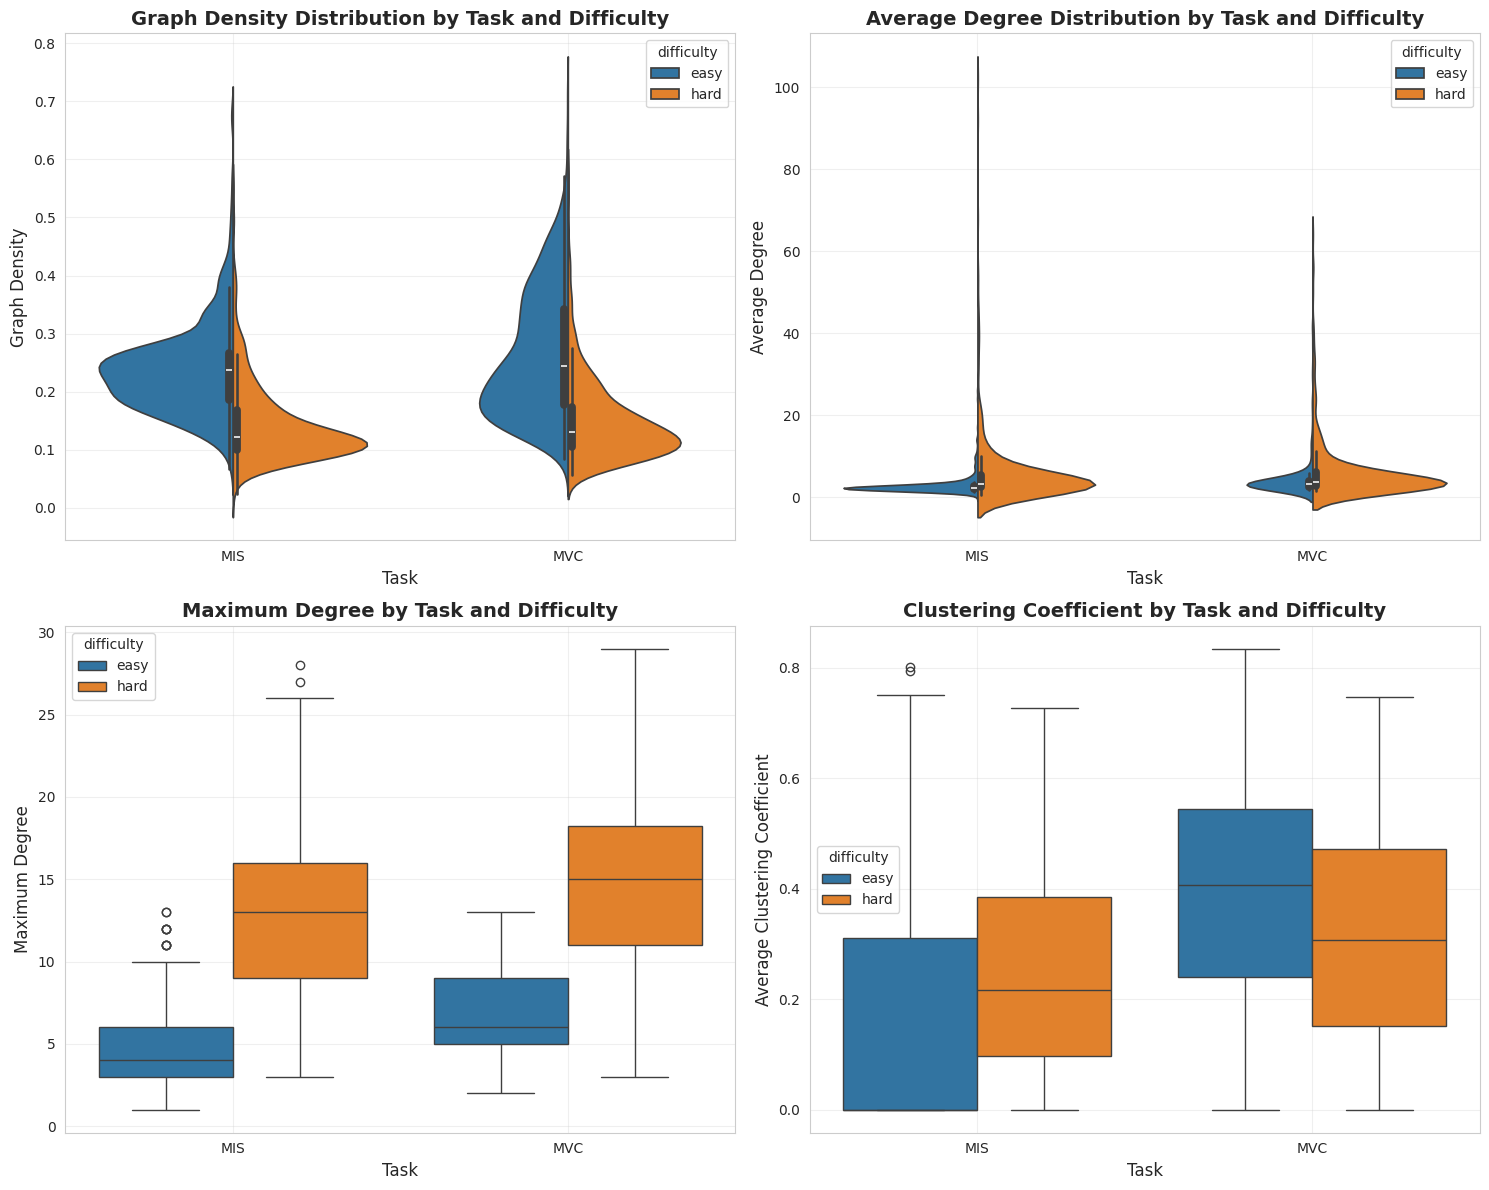

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Graph Density
sns.violinplot(data=df_stats, x='task', y='density', hue='difficulty', ax=axes[0, 0], split=True)
axes[0, 0].set_xlabel('Task', fontsize=12)
axes[0, 0].set_ylabel('Graph Density', fontsize=12)
axes[0, 0].set_title('Graph Density Distribution by Task and Difficulty', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Average Degree
sns.violinplot(data=df_stats, x='task', y='avg_degree', hue='difficulty', ax=axes[0, 1], split=True)
axes[0, 1].set_xlabel('Task', fontsize=12)
axes[0, 1].set_ylabel('Average Degree', fontsize=12)
axes[0, 1].set_title('Average Degree Distribution by Task and Difficulty', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Maximum Degree
sns.boxplot(data=df_stats, x='task', y='max_degree', hue='difficulty', ax=axes[1, 0])
axes[1, 0].set_xlabel('Task', fontsize=12)
axes[1, 0].set_ylabel('Maximum Degree', fontsize=12)
axes[1, 0].set_title('Maximum Degree by Task and Difficulty', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Clustering Coefficient
sns.boxplot(data=df_stats, x='task', y='avg_clustering', hue='difficulty', ax=axes[1, 1])
axes[1, 1].set_xlabel('Task', fontsize=12)
axes[1, 1].set_ylabel('Average Clustering Coefficient', fontsize=12)
axes[1, 1].set_title('Clustering Coefficient by Task and Difficulty', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Connectivity Analysis

In [10]:
# Connectivity statistics
connectivity_stats = df_stats.groupby(['task', 'difficulty']).agg({
    'is_connected': ['sum', 'count'],
    'num_components': ['mean', 'max']
})

print("Connectivity Statistics:")
print(connectivity_stats)
print("\n")

# Calculate percentage of connected graphs
for task in ['MIS', 'MVC']:
    for diff in ['easy', 'hard']:
        subset = df_stats[(df_stats['task'] == task) & (df_stats['difficulty'] == diff)]
        connected_count = subset['is_connected'].sum()
        total = len(subset)
        pct = (connected_count / total * 100) if total > 0 else 0
        print(f"{task} - {diff}: {connected_count}/{total} ({pct:.1f}%) graphs are connected")

Connectivity Statistics:
                is_connected       num_components    
                         sum count           mean max
task difficulty                                      
MIS  easy                  0   500          2.286   7
     hard                  0   500          2.704  17
MVC  easy                  0   500          2.342   6
     hard                  0   500          2.666  10


MIS - easy: 0/500 (0.0%) graphs are connected
MIS - hard: 0/500 (0.0%) graphs are connected
MVC - easy: 0/500 (0.0%) graphs are connected
MVC - hard: 0/500 (0.0%) graphs are connected


## 7. Degree Distribution Analysis

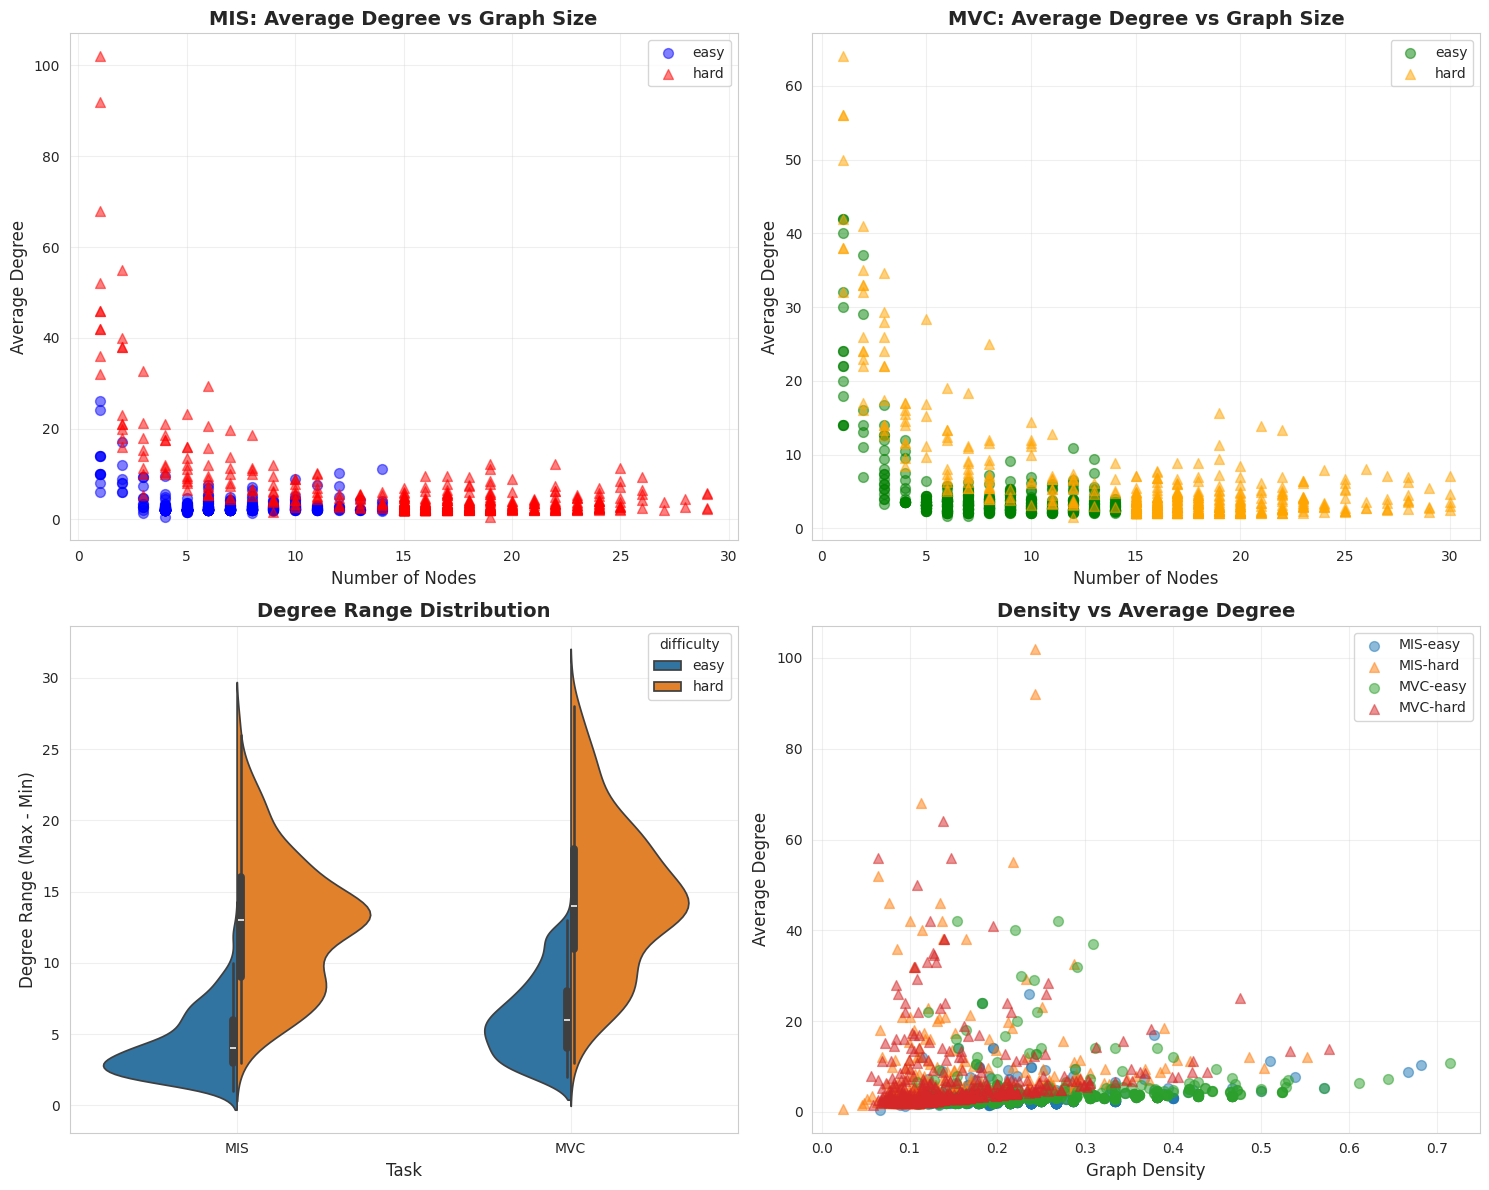

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Average degree vs Number of nodes (MIS)
mis_data = df_stats[df_stats['task'] == 'MIS']
for diff, color, marker in zip(['easy', 'hard'], ['blue', 'red'], ['o', '^']):
    data = mis_data[mis_data['difficulty'] == diff]
    axes[0, 0].scatter(data['num_nodes'], data['avg_degree'], 
                      alpha=0.5, label=diff, color=color, marker=marker, s=50)
axes[0, 0].set_xlabel('Number of Nodes', fontsize=12)
axes[0, 0].set_ylabel('Average Degree', fontsize=12)
axes[0, 0].set_title('MIS: Average Degree vs Graph Size', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Average degree vs Number of nodes (MVC)
mvc_data = df_stats[df_stats['task'] == 'MVC']
for diff, color, marker in zip(['easy', 'hard'], ['green', 'orange'], ['o', '^']):
    data = mvc_data[mvc_data['difficulty'] == diff]
    axes[0, 1].scatter(data['num_nodes'], data['avg_degree'], 
                      alpha=0.5, label=diff, color=color, marker=marker, s=50)
axes[0, 1].set_xlabel('Number of Nodes', fontsize=12)
axes[0, 1].set_ylabel('Average Degree', fontsize=12)
axes[0, 1].set_title('MVC: Average Degree vs Graph Size', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Degree range (max - min) by difficulty
df_stats['degree_range'] = df_stats['max_degree'] - df_stats['min_degree']
sns.violinplot(data=df_stats, x='task', y='degree_range', hue='difficulty', ax=axes[1, 0], split=True)
axes[1, 0].set_xlabel('Task', fontsize=12)
axes[1, 0].set_ylabel('Degree Range (Max - Min)', fontsize=12)
axes[1, 0].set_title('Degree Range Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Density vs Average Degree
for task, color in zip(['MIS', 'MVC'], ['blue', 'green']):
    task_data = df_stats[df_stats['task'] == task]
    for diff, marker in zip(['easy', 'hard'], ['o', '^']):
        data = task_data[task_data['difficulty'] == diff]
        axes[1, 1].scatter(data['density'], data['avg_degree'], 
                          alpha=0.5, label=f'{task}-{diff}', marker=marker, s=50)
axes[1, 1].set_xlabel('Graph Density', fontsize=12)
axes[1, 1].set_ylabel('Average Degree', fontsize=12)
axes[1, 1].set_title('Density vs Average Degree', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Comparison: MIS vs MVC

In [12]:
# Statistical comparison between MIS and MVC
print("="*80)
print("STATISTICAL COMPARISON: MIS vs MVC")
print("="*80)

comparison_metrics = ['num_nodes', 'num_edges', 'density', 'avg_degree', 'max_degree', 'avg_clustering']

for metric in comparison_metrics:
    print(f"\n{metric.upper()}:")
    for diff in ['easy', 'hard']:
        mis_vals = df_stats[(df_stats['task'] == 'MIS') & (df_stats['difficulty'] == diff)][metric]
        mvc_vals = df_stats[(df_stats['task'] == 'MVC') & (df_stats['difficulty'] == diff)][metric]
        
        print(f"  {diff.capitalize()}:")
        print(f"    MIS: mean={mis_vals.mean():.2f}, std={mis_vals.std():.2f}, median={mis_vals.median():.2f}")
        print(f"    MVC: mean={mvc_vals.mean():.2f}, std={mvc_vals.std():.2f}, median={mvc_vals.median():.2f}")
        print(f"    Difference (MIS-MVC): {mis_vals.mean() - mvc_vals.mean():.2f}")

STATISTICAL COMPARISON: MIS vs MVC

NUM_NODES:
  Easy:
    MIS: mean=6.36, std=2.64, median=6.00
    MVC: mean=8.13, std=3.26, median=8.00
    Difference (MIS-MVC): -1.76
  Hard:
    MIS: mean=15.77, std=6.02, median=16.00
    MVC: mean=15.75, std=6.34, median=16.00
    Difference (MIS-MVC): 0.03

NUM_EDGES:
  Easy:
    MIS: mean=8.74, std=6.57, median=7.00
    MVC: mean=14.36, std=7.10, median=13.00
    Difference (MIS-MVC): -5.63
  Hard:
    MIS: mean=31.40, std=17.84, median=26.00
    MVC: mean=33.53, std=18.53, median=29.00
    Difference (MIS-MVC): -2.12

DENSITY:
  Easy:
    MIS: mean=0.24, std=0.08, median=0.24
    MVC: mean=0.27, std=0.11, median=0.24
    Difference (MIS-MVC): -0.03
  Hard:
    MIS: mean=0.14, std=0.07, median=0.12
    MVC: mean=0.15, std=0.07, median=0.13
    Difference (MIS-MVC): -0.01

AVG_DEGREE:
  Easy:
    MIS: mean=2.93, std=2.33, median=2.29
    MVC: mean=4.41, std=4.78, median=3.20
    Difference (MIS-MVC): -1.47
  Hard:
    MIS: mean=6.07, std=9.48, m

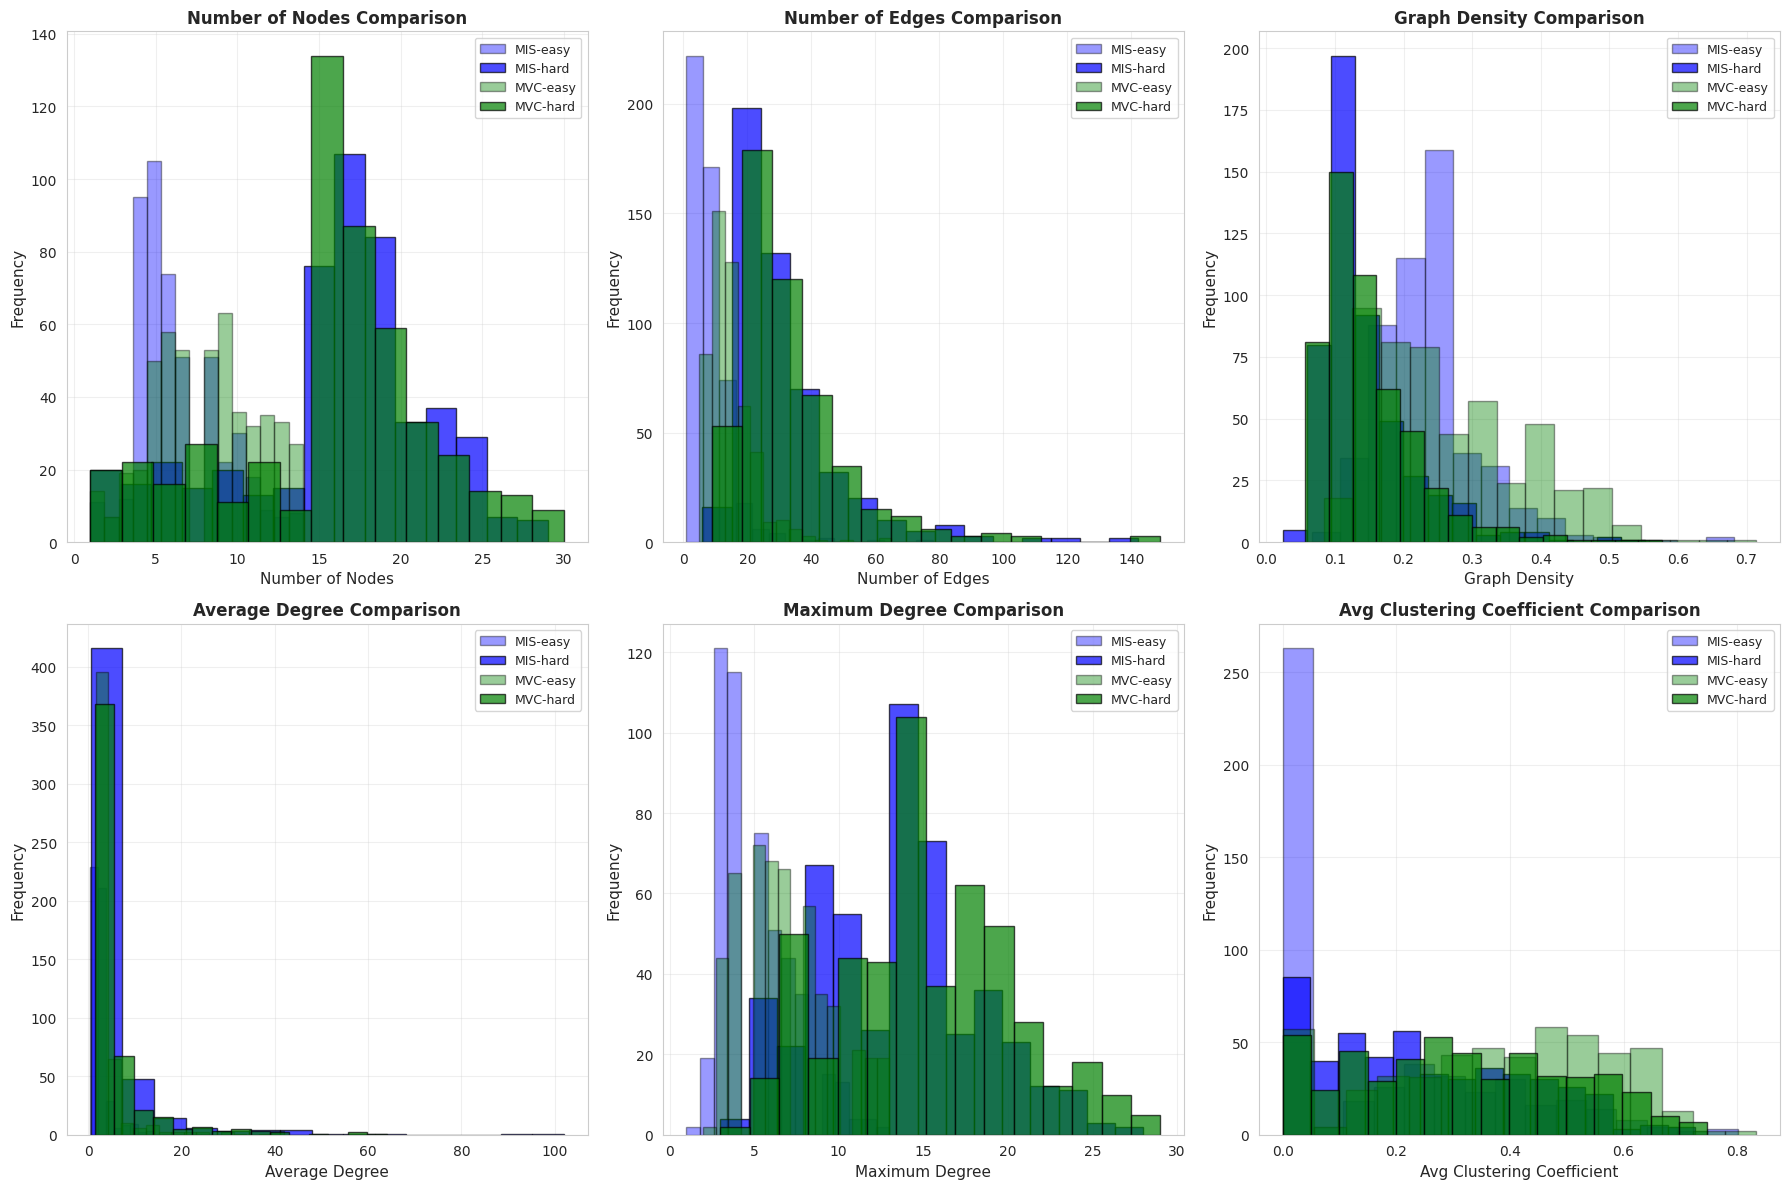

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = [
    ('num_nodes', 'Number of Nodes'),
    ('num_edges', 'Number of Edges'),
    ('density', 'Graph Density'),
    ('avg_degree', 'Average Degree'),
    ('max_degree', 'Maximum Degree'),
    ('avg_clustering', 'Avg Clustering Coefficient')
]

for idx, (metric, title) in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    
    # Create comparison plot
    for task, color in zip(['MIS', 'MVC'], ['blue', 'green']):
        for diff, alpha in zip(['easy', 'hard'], [0.4, 0.7]):
            data = df_stats[(df_stats['task'] == task) & (df_stats['difficulty'] == diff)][metric]
            axes[row, col].hist(data, alpha=alpha, label=f'{task}-{diff}', 
                               bins=15, edgecolor='black', color=color)
    
    axes[row, col].set_xlabel(title, fontsize=11)
    axes[row, col].set_ylabel('Frequency', fontsize=11)
    axes[row, col].set_title(f'{title} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].legend(fontsize=9)
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Sample Graph Visualization

MIS - Easy Difficulty:


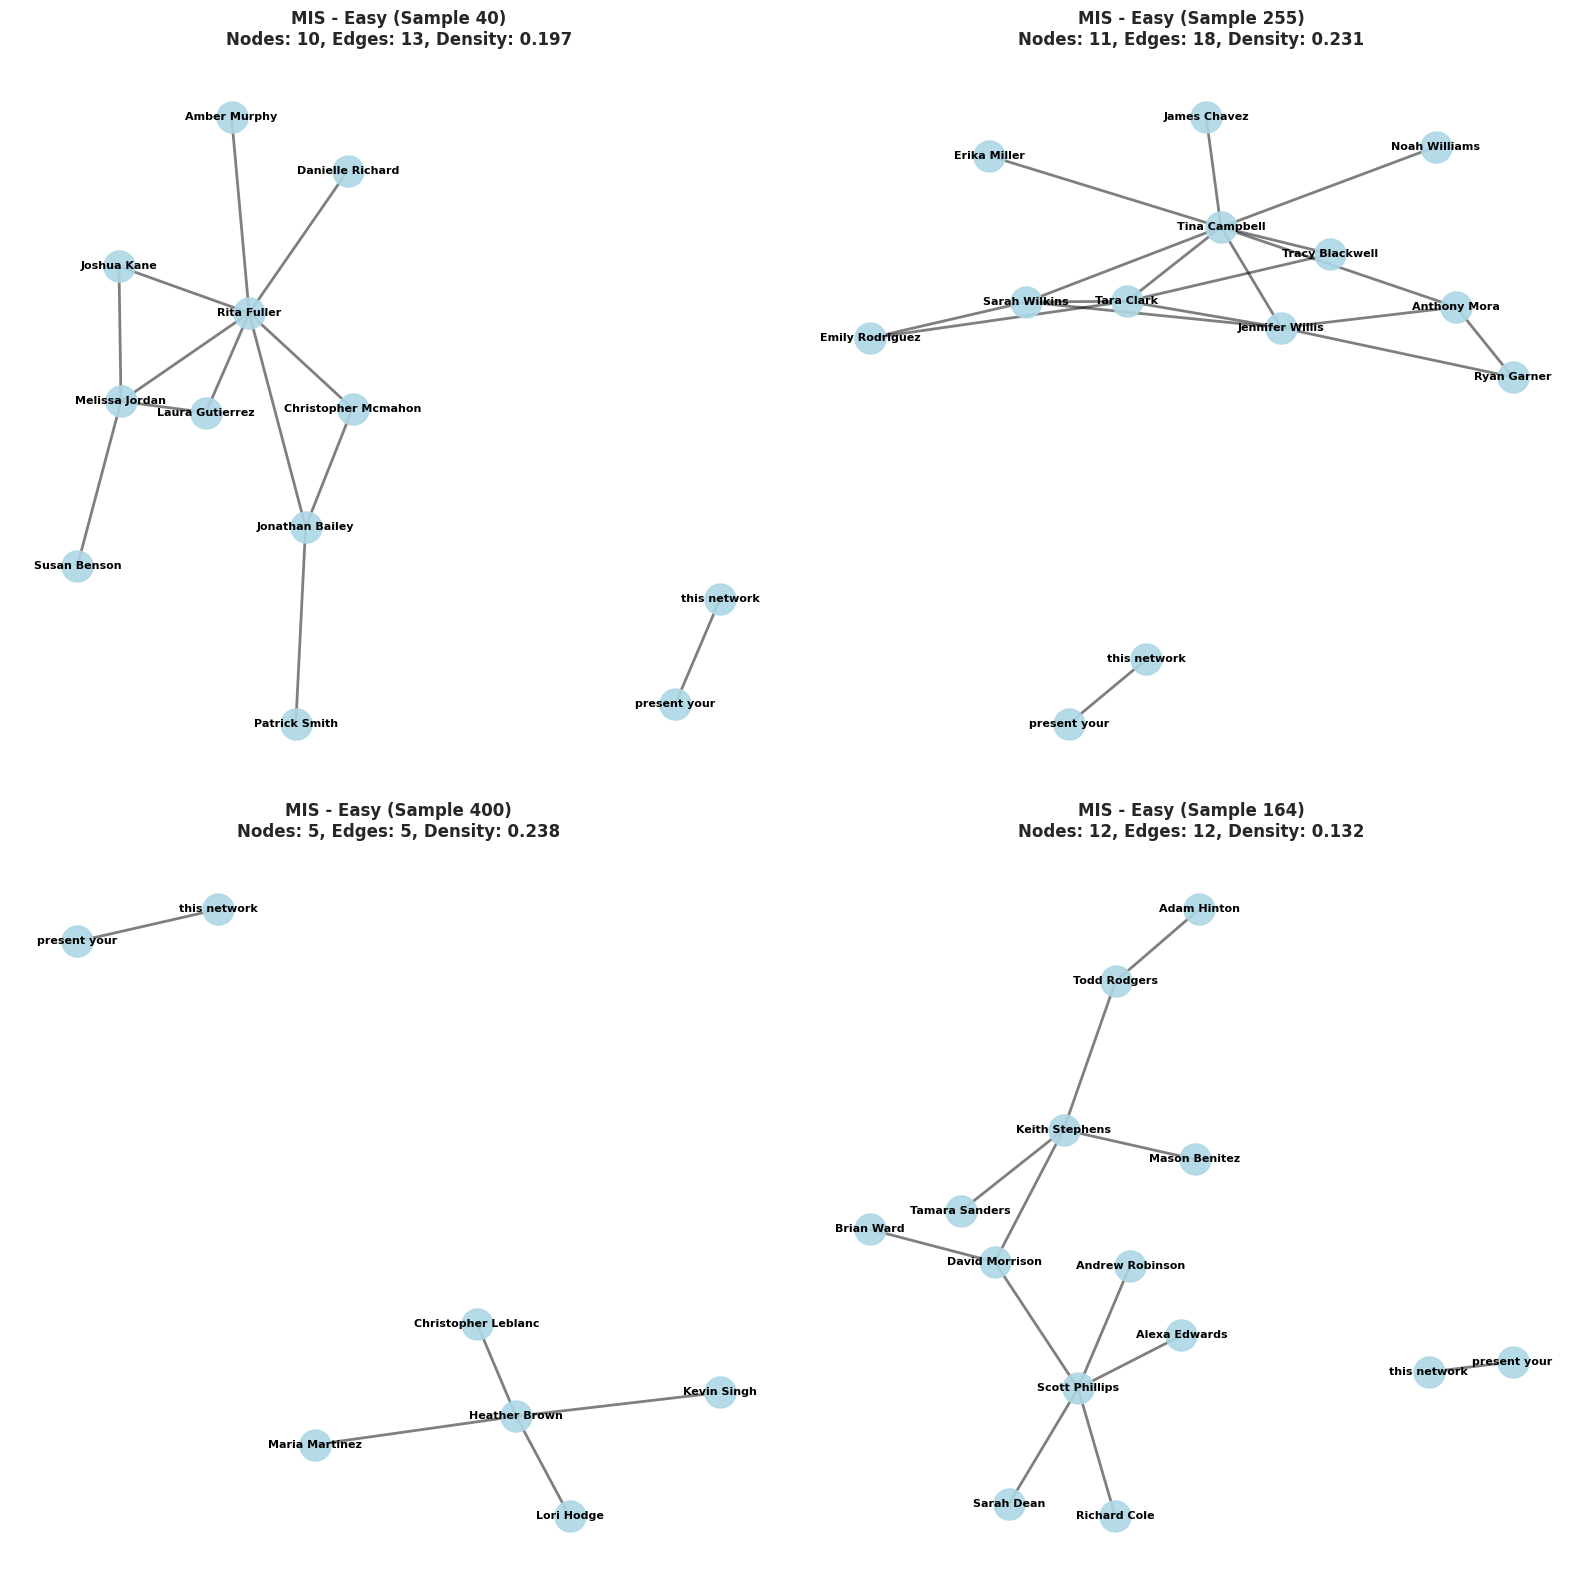

In [14]:
def visualize_sample_graphs(data_dict, task, difficulty, num_samples=4):
    """Visualize sample graphs from the dataset"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    axes = axes.flatten()
    
    problems = data_dict[task][difficulty]
    samples = np.random.choice(len(problems), min(num_samples, len(problems)), replace=False)
    
    for idx, sample_idx in enumerate(samples):
        problem_text = problems[sample_idx]
        nodes, edges = parse_graph_from_text(problem_text)
        
        # Create graph
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        
        # Draw graph
        pos = nx.spring_layout(G, k=0.5, iterations=50)
        
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                              node_size=500, ax=axes[idx], alpha=0.9)
        nx.draw_networkx_edges(G, pos, ax=axes[idx], alpha=0.5, width=2)
        nx.draw_networkx_labels(G, pos, ax=axes[idx], font_size=8, font_weight='bold')
        
        axes[idx].set_title(f'{task} - {difficulty.capitalize()} (Sample {sample_idx})\n'
                           f'Nodes: {len(nodes)}, Edges: {len(edges)}, '
                           f'Density: {nx.density(G):.3f}',
                           fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
print("MIS - Easy Difficulty:")
visualize_sample_graphs(all_data['0shot.json'], 'MIS', 'easy')

MIS - Hard Difficulty:


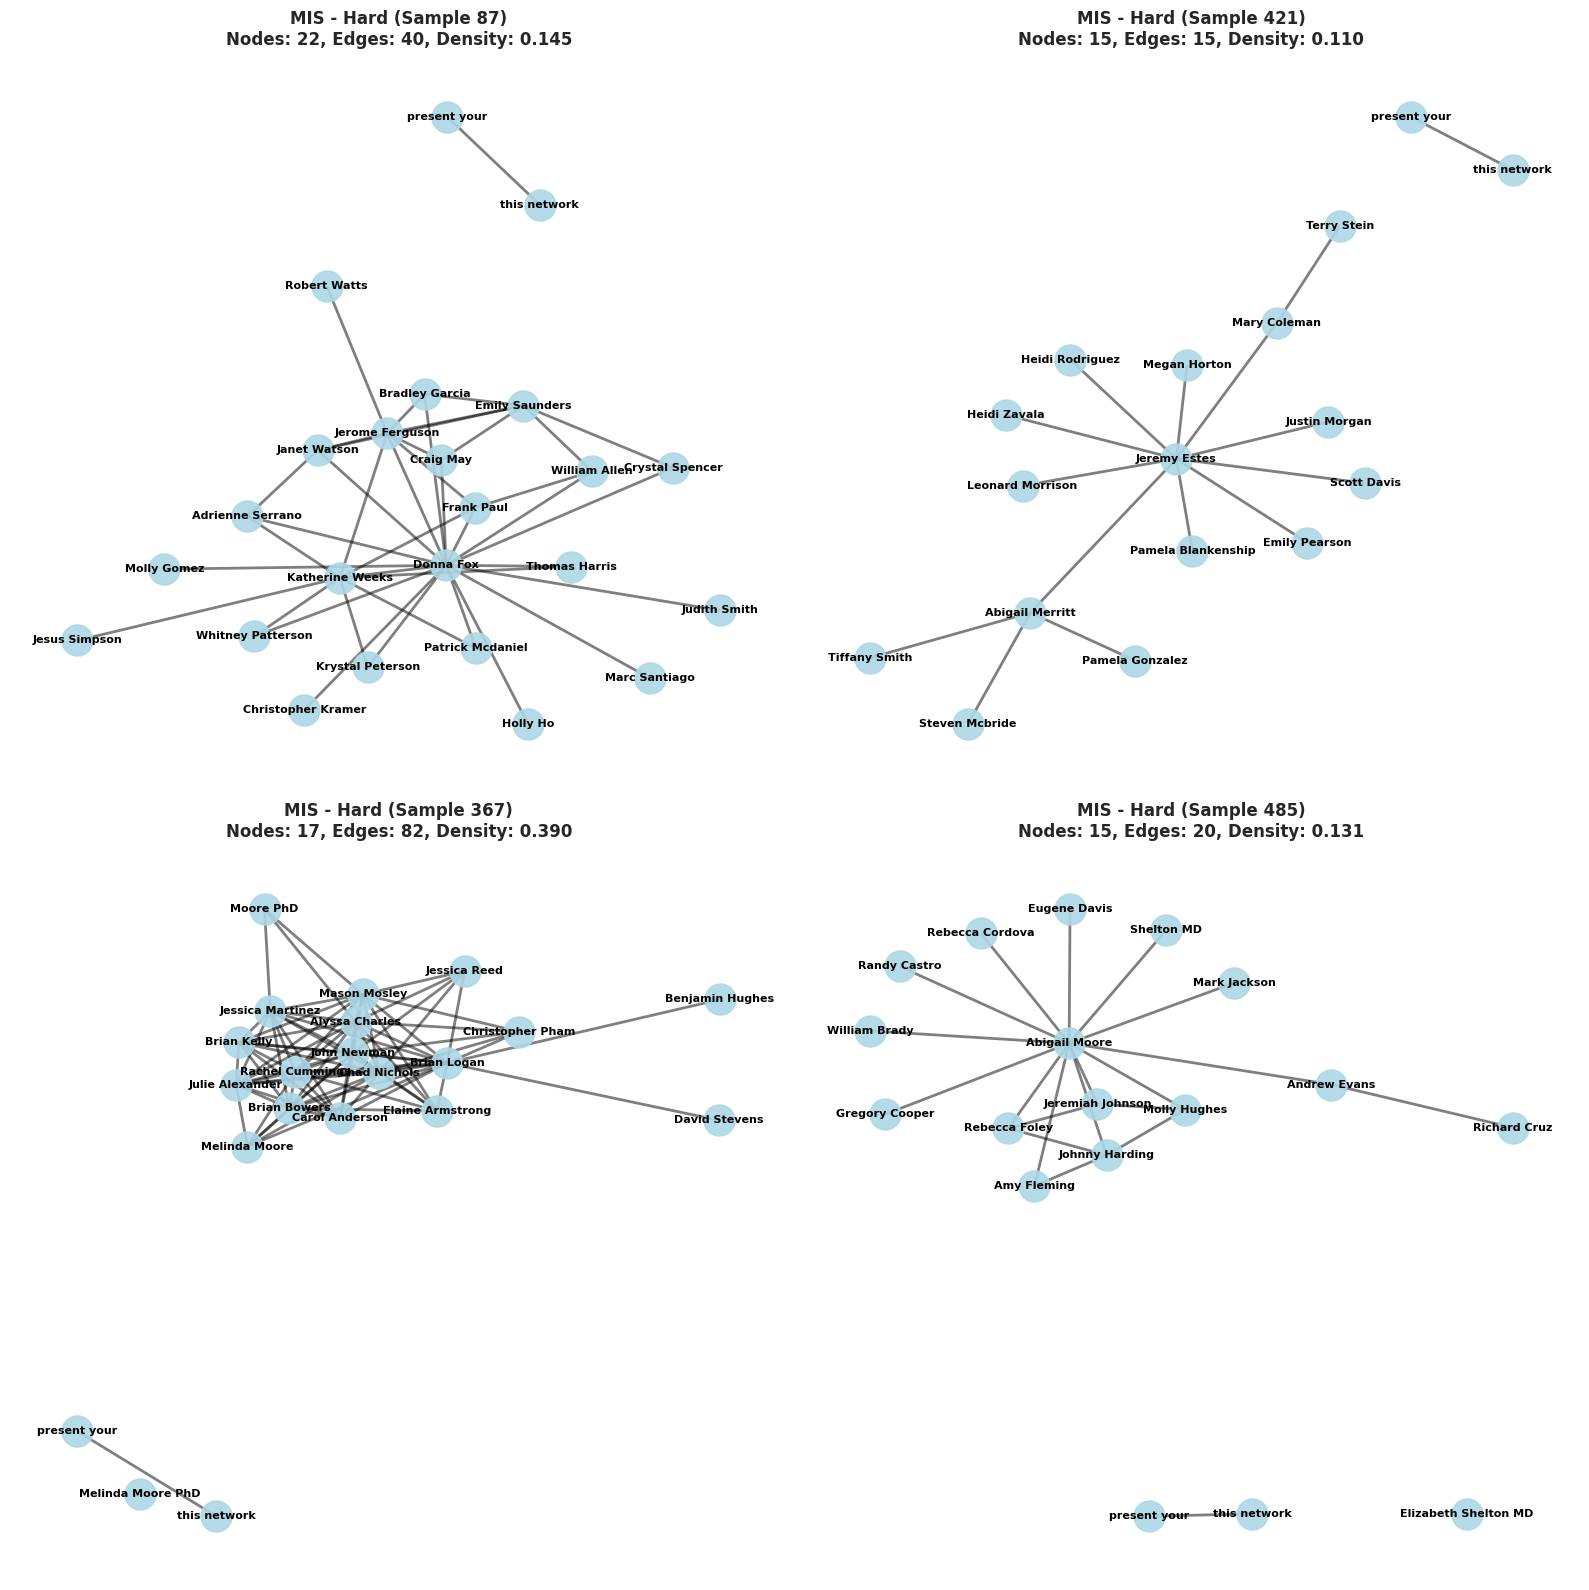

In [15]:
print("MIS - Hard Difficulty:")
visualize_sample_graphs(all_data['0shot.json'], 'MIS', 'hard')

MVC - Easy Difficulty:


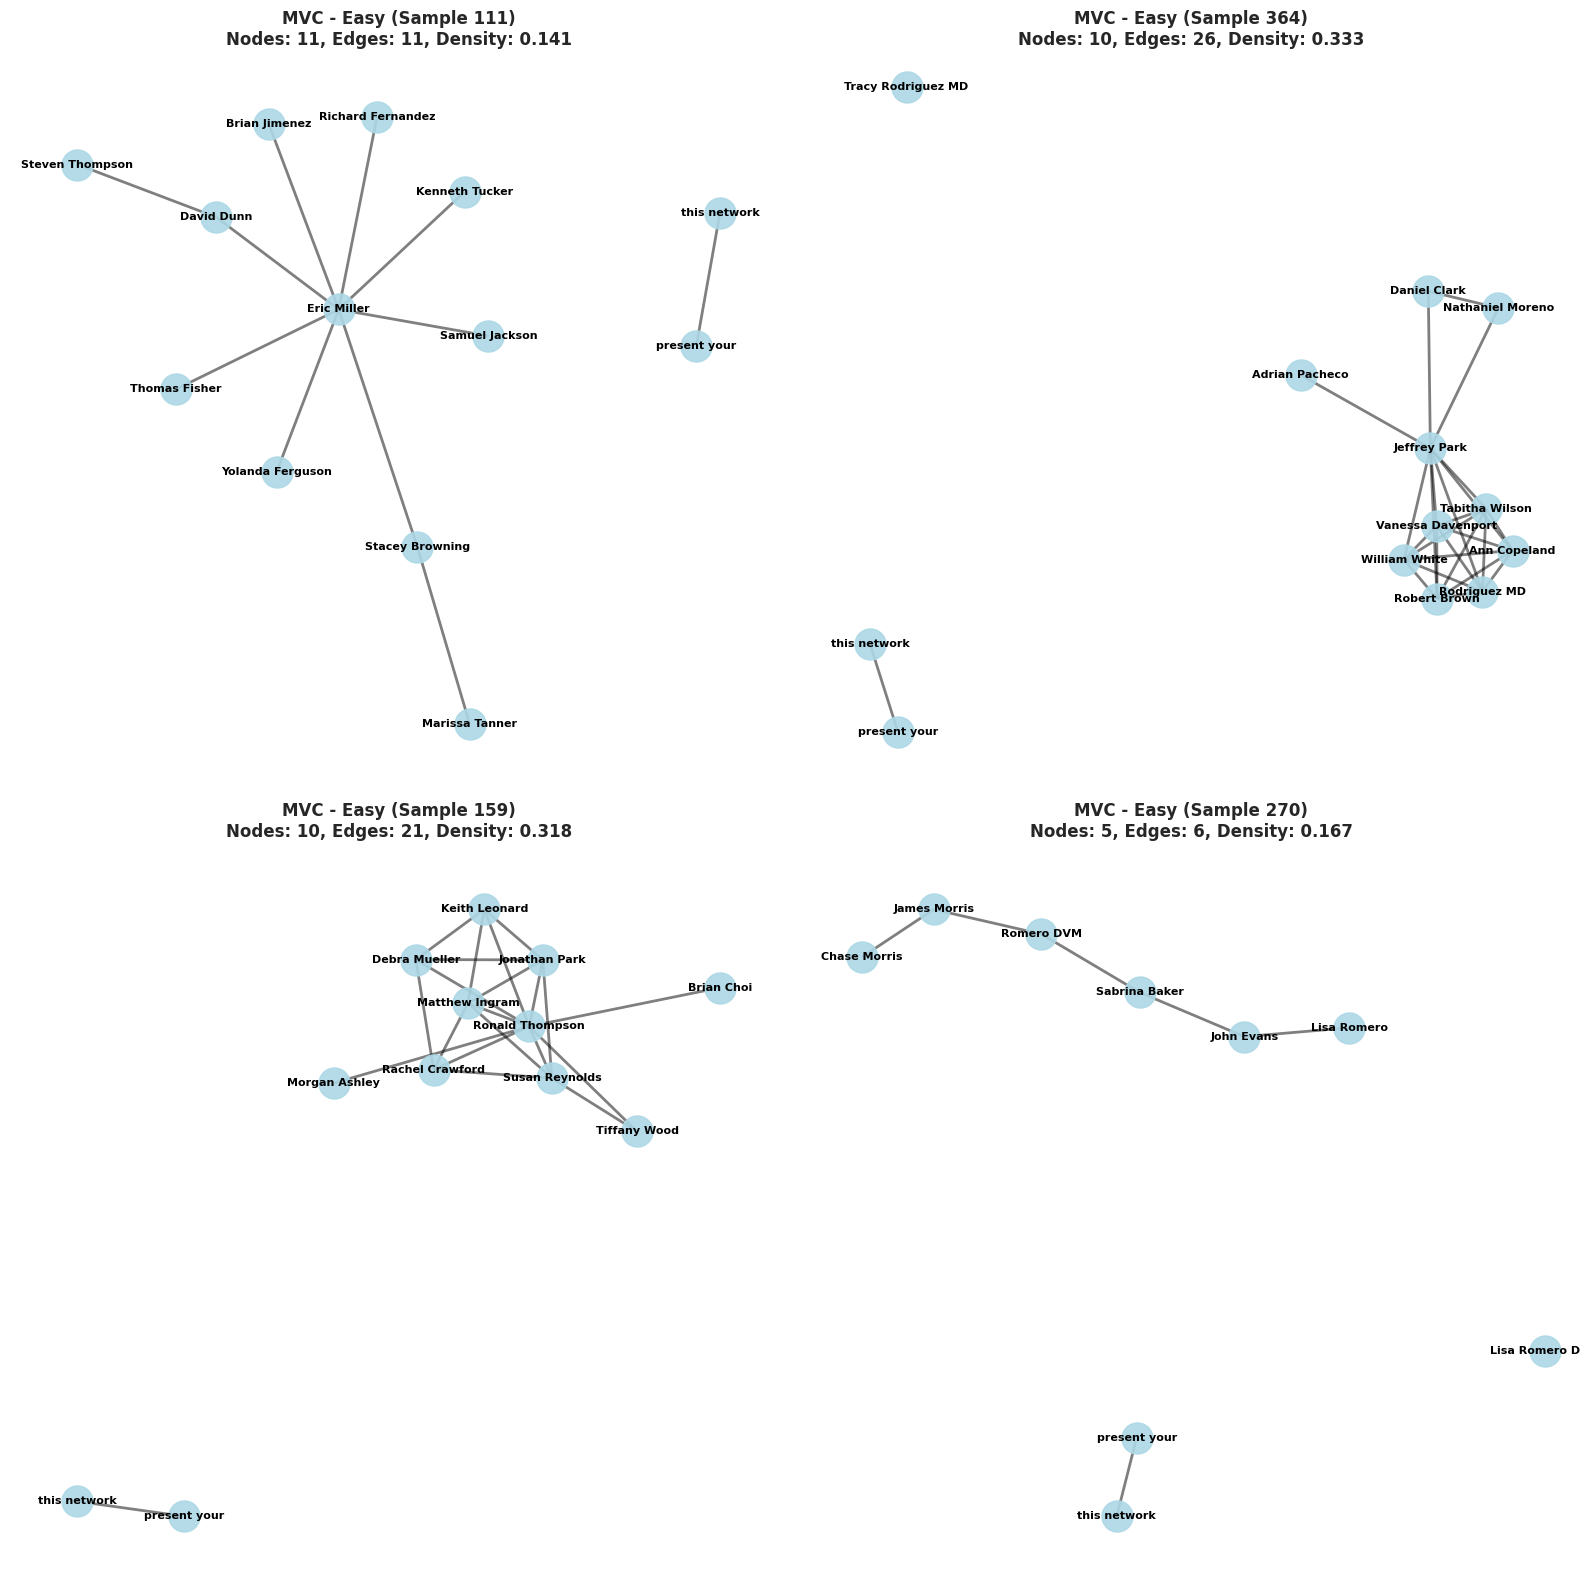

In [16]:
print("MVC - Easy Difficulty:")
visualize_sample_graphs(all_data['0shot.json'], 'MVC', 'easy')

MVC - Hard Difficulty:


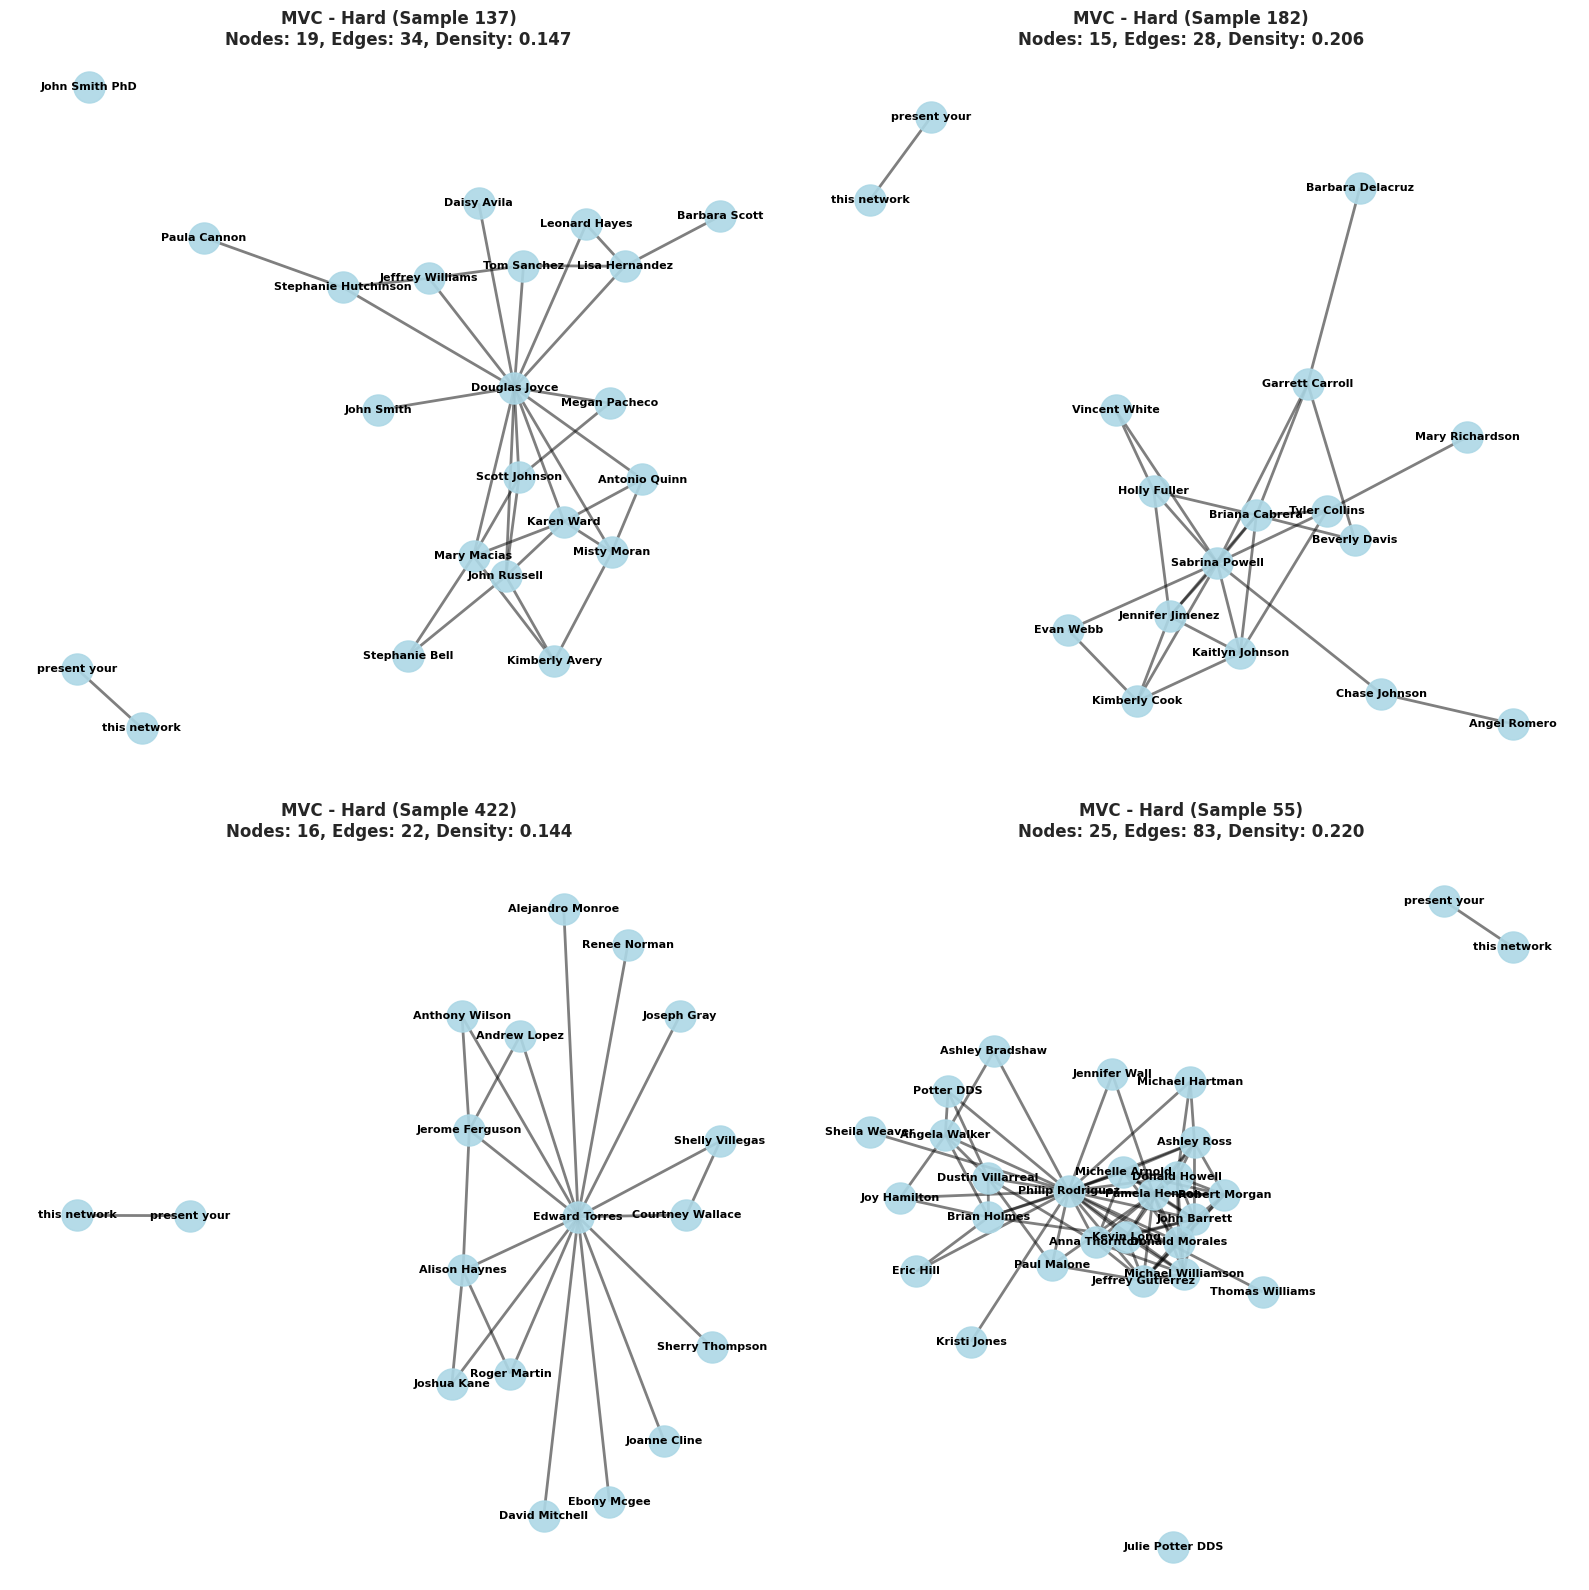

In [17]:
print("MVC - Hard Difficulty:")
visualize_sample_graphs(all_data['0shot.json'], 'MVC', 'hard')

## 10. Key Insights and Summary

In [18]:
print("="*80)
print("KEY INSIGHTS FROM EDA")
print("="*80)

print("\n1. DATASET SIZE:")
print(f"   - Total MIS problems: {len(df_stats[df_stats['task'] == 'MIS'])}")
print(f"   - Total MVC problems: {len(df_stats[df_stats['task'] == 'MVC'])}")
print(f"   - Easy problems per task: {len(df_stats[(df_stats['task'] == 'MIS') & (df_stats['difficulty'] == 'easy')])}")
print(f"   - Hard problems per task: {len(df_stats[(df_stats['task'] == 'MIS') & (df_stats['difficulty'] == 'hard')])}")

print("\n2. GRAPH SIZE CHARACTERISTICS:")
for task in ['MIS', 'MVC']:
    print(f"\n   {task}:")
    for diff in ['easy', 'hard']:
        subset = df_stats[(df_stats['task'] == task) & (df_stats['difficulty'] == diff)]
        print(f"     {diff.capitalize()}: Nodes [{subset['num_nodes'].min():.0f}-{subset['num_nodes'].max():.0f}], "
              f"Edges [{subset['num_edges'].min():.0f}-{subset['num_edges'].max():.0f}]")

print("\n3. CONNECTIVITY:")
for task in ['MIS', 'MVC']:
    for diff in ['easy', 'hard']:
        subset = df_stats[(df_stats['task'] == task) & (df_stats['difficulty'] == diff)]
        pct = (subset['is_connected'].sum() / len(subset)) * 100
        avg_components = subset['num_components'].mean()
        print(f"   {task} - {diff}: {pct:.1f}% connected, avg {avg_components:.2f} components")

print("\n4. GRAPH PROPERTIES:")
for task in ['MIS', 'MVC']:
    print(f"\n   {task}:")
    subset = df_stats[df_stats['task'] == task]
    print(f"     Average density: {subset['density'].mean():.3f}")
    print(f"     Average degree: {subset['avg_degree'].mean():.2f}")
    print(f"     Average clustering coefficient: {subset['avg_clustering'].mean():.3f}")

print("\n5. DIFFICULTY COMPARISON:")
for task in ['MIS', 'MVC']:
    easy = df_stats[(df_stats['task'] == task) & (df_stats['difficulty'] == 'easy')]
    hard = df_stats[(df_stats['task'] == task) & (df_stats['difficulty'] == 'hard')]
    print(f"\n   {task}:")
    print(f"     Easy - Avg nodes: {easy['num_nodes'].mean():.1f}, Avg edges: {easy['num_edges'].mean():.1f}")
    print(f"     Hard - Avg nodes: {hard['num_nodes'].mean():.1f}, Avg edges: {hard['num_edges'].mean():.1f}")
    print(f"     Node increase (easy→hard): {((hard['num_nodes'].mean() - easy['num_nodes'].mean()) / easy['num_nodes'].mean() * 100):.1f}%")

print("\n6. MIS vs MVC DIFFERENCES:")
mis_data = df_stats[df_stats['task'] == 'MIS']
mvc_data = df_stats[df_stats['task'] == 'MVC']
print(f"   Average nodes - MIS: {mis_data['num_nodes'].mean():.2f}, MVC: {mvc_data['num_nodes'].mean():.2f}")
print(f"   Average edges - MIS: {mis_data['num_edges'].mean():.2f}, MVC: {mvc_data['num_edges'].mean():.2f}")
print(f"   Average density - MIS: {mis_data['density'].mean():.3f}, MVC: {mvc_data['density'].mean():.3f}")

print("\n" + "="*80)

KEY INSIGHTS FROM EDA

1. DATASET SIZE:
   - Total MIS problems: 1000
   - Total MVC problems: 1000
   - Easy problems per task: 500
   - Hard problems per task: 500

2. GRAPH SIZE CHARACTERISTICS:

   MIS:
     Easy: Nodes [1-14], Edges [1-78]
     Hard: Nodes [1-29], Edges [6-142]

   MVC:
     Easy: Nodes [1-14], Edges [5-65]
     Hard: Nodes [1-30], Edges [9-149]

3. CONNECTIVITY:
   MIS - easy: 0.0% connected, avg 2.29 components
   MIS - hard: 0.0% connected, avg 2.70 components
   MVC - easy: 0.0% connected, avg 2.34 components
   MVC - hard: 0.0% connected, avg 2.67 components

4. GRAPH PROPERTIES:

   MIS:
     Average density: 0.191
     Average degree: 4.50
     Average clustering coefficient: 0.203

   MVC:
     Average density: 0.208
     Average degree: 5.31
     Average clustering coefficient: 0.347

5. DIFFICULTY COMPARISON:

   MIS:
     Easy - Avg nodes: 6.4, Avg edges: 8.7
     Hard - Avg nodes: 15.8, Avg edges: 31.4
     Node increase (easy→hard): 147.9%

   MVC:
  

## 11. Save Processed Data

In [19]:
# Save the statistics DataFrame for future use
df_stats.to_csv('graph_statistics_MIS_MVC.csv', index=False)
print("Graph statistics saved to 'graph_statistics_MIS_MVC.csv'")

# Display final summary
print("\nFinal DataFrame Info:")
print(df_stats.info())
print("\nFirst few rows:")
df_stats.head(10)

Graph statistics saved to 'graph_statistics_MIS_MVC.csv'

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   task            2000 non-null   object 
 1   difficulty      2000 non-null   object 
 2   problem_id      2000 non-null   int64  
 3   num_nodes       2000 non-null   int64  
 4   num_edges       2000 non-null   int64  
 5   density         2000 non-null   float64
 6   avg_degree      2000 non-null   float64
 7   max_degree      2000 non-null   int64  
 8   min_degree      2000 non-null   int64  
 9   is_connected    2000 non-null   bool   
 10  num_components  2000 non-null   int64  
 11  avg_clustering  2000 non-null   float64
 12  diameter        0 non-null      object 
 13  degree_range    2000 non-null   int64  
dtypes: bool(1), float64(3), int64(7), object(3)
memory usage: 205.2+ KB
None

First few rows

,task,difficulty,problem_id,num_nodes,num_edges,density,avg_degree,max_degree,min_degree,is_connected,num_components,avg_clustering,diameter,degree_range
0,MIS,easy,0,4,4,0.266667,2.000000,2,1,False,2,0.000000,None,1
1,MIS,easy,1,3,11,0.120879,7.333333,6,0,False,3,0.000000,None,6
2,MIS,easy,2,5,5,0.238095,2.000000,4,1,False,2,0.000000,None,3
3,MIS,easy,3,4,5,0.178571,2.500000,3,0,False,3,0.000000,None,3
4,MIS,easy,4,9,14,0.254545,3.111111,8,1,False,2,0.349567,None,7
5,MIS,easy,5,9,10,0.181818,2.222222,8,1,False,2,0.185065,None,7
6,MIS,easy,6,8,11,0.200000,2.750000,7,0,False,3,0.331169,None,7
7,MIS,easy,7,4,4,0.190476,2.000000,3,0,False,3,0.000000,None,3
8,MIS,easy,8,3,2,0.095238,1.333333,1,0,False,5,0.000000,None,1
9,MIS,easy,9,6,6,0.214286,2.000000,5,1,False,2,0.000000,None,4
